# YOLOv2-Tiny-Quant
This notebook shows an example of object detection of an image.
The network that is used for inference is a variant of Tiny-Yolov2, whose topology is illustrated in the following picture.
The pynq colored layers will be executed in python, while the other layers are executed in the HW accelerator.

The image processing is performed within darknet by using python bindings.


![Tinier-YOLO-topology](Tinier-YOLO-topology.png)

In [1]:
import time
from pynq import Overlay
import numpy as np
from pynq import Xlnk
import struct
import cv2
import matplotlib.pyplot as plt

In [2]:
# 卷积和池化驱动
def RunConv(conv,Kx,Ky,Sx,Sy,mode,relu_en,feature_in,W,bias,feature_out,qmax):
    conv.write(0x10,feature_in.shape[2])
    conv.write(0x18,feature_in.shape[0])
    conv.write(0x20,feature_in.shape[1])
    conv.write(0x28,feature_out.shape[2])
    conv.write(0x30,Kx)
    conv.write(0x38,Ky)
    conv.write(0x40,Sx)
    conv.write(0x48,Sy)
    conv.write(0x50,mode)
    conv.write(0x58,relu_en)
    conv.write(0x60,feature_in.physical_address)
    conv.write(0x68,W.physical_address)
    conv.write(0x70,bias.physical_address)
    conv.write(0x78,feature_out.physical_address)
    conv.write(0x80,qmax.physical_address)
    conv.write(0, (conv.read(0)&0x80)|0x01)
    tp=conv.read(0)
    while not ((tp>>1)&0x1):
        tp=conv.read(0)

def RunPool(pool,Kx,Ky,mode,feature_in,feature_out):
    pool.write(0x10,feature_in.shape[2])
    pool.write(0x18,feature_in.shape[0])
    pool.write(0x20,feature_in.shape[1])
    pool.write(0x28,Kx)
    pool.write(0x30,Ky)
    pool.write(0x38,mode)
    pool.write(0x40,feature_in.physical_address)
    pool.write(0x48,feature_out.physical_address)
    pool.write(0, (pool.read(0)&0x80)|0x01)
    while not ((pool.read(0)>>1)&0x1):
        pass

In [3]:
# 下载比特流文件，加载卷积和池化IP核
xlnk=Xlnk()
ol=Overlay("yolo.bit")
ol.download()
conv_ip=ol.Conv_0
pool_ip=ol.Pool_0
print("Overlay download finish")

/usr/local/lib/python3.6/dist-packages/pynq/pl_server/device.py:594: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)


Overlay download finish


## 调用卷积和池化IP核，执行第五层卷积层和最大池化层

In [4]:
# 导入第四层最大池化层的输出特征值
# 导入第五层卷积层的权重
feature = np.loadtxt('./feature_output/max4_output.txt').astype(np.float32)
load_weights = np.loadtxt('./weights/w5.txt').astype(np.float32)

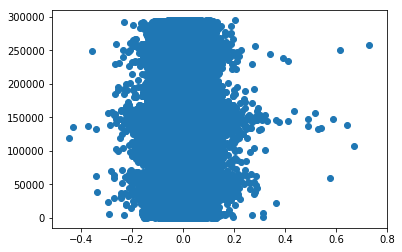

In [5]:
# 绘制权重的散列图
y = range(0,3*3*128*256)
plt.scatter(load_weights, y)
plt.savefig('./conv5_weights.png')

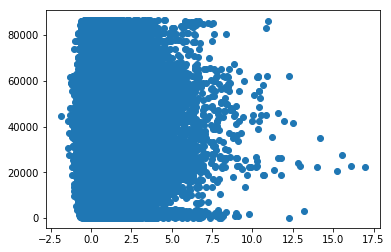

In [6]:
# 绘制特征值的散列图
y = range(0,26*26*128)
plt.scatter(feature, y)
plt.savefig('./conv5_feature.png')

In [7]:
#最大量化，返回量化后参数和最大值
# max_feature: 找出特征值的最大值
# feature_quant：量化后的特征值 fp32 -> int8
# max_weight：找出权重的最大值
# load_weights_quant：量化后的权重值  fp32 -> int8

#TODO
max_feature = max(abs(feature))#TODO
feature_quant = (127*feature/max_feature).astype(np.int8)#TODO
max_weight = max(abs(load_weights))#TODO
load_weights_quant =(127*load_weights/max_weight).astype(np.int8) #TODO

In [8]:
# reshape 量化后的第四层最大池化层特征值，拷贝到第五层卷积层的输入特征值
# feature已经被量化，类型值dtype=np.int8
feature = np.reshape(feature_quant,(26,26,128))
conv5_in = xlnk.cma_array(shape=(26,26,128),cacheable=0,dtype=np.int8)
np.copyto(conv5_in,feature)

# 为weights、bias和cov5_output分配连续的物理地址空间
# weights已经被量化，类型值dtype=np.int8
# bias不做量化，类型值dtype=np.float32
# conv5_output 输出特征值要去量化，类型值dtype=np.float32
weights = xlnk.cma_array(shape=(3,3,128,256),cacheable=0,dtype=np.int8)
bias = xlnk.cma_array(shape=(256),cacheable=0,dtype=np.float32)
conv5_output = xlnk.cma_array(shape=(26,26,256),cacheable=0,dtype=np.float32)

# reshape 量化后的权重值，拷贝给第五层卷积层的权重weights
load_weights = np.reshape(load_weights_quant,(3,3,128,256))
np.copyto(weights,load_weights)

# 导入第五层卷积层的bias
load_bias = np.loadtxt('./bias/b5.txt')
np.copyto(bias,load_bias)

# 将上一个cell求出的max_feature和max_weight导入卷积IP核，去量化
maxw5_w = xlnk.cma_array(shape=(2),cacheable=0,dtype=np.float32)
max_w = [max_feature,max_weight]
np.copyto(maxw5_w,max_w)

In [9]:
# 执行第五层卷积层IP核，conv5_output需要去量化
start = time.clock()
RunConv(conv_ip,3,3,1,1,1,0,conv5_in,weights,bias,conv5_output,maxw5_w)
end = time.clock()
print(end-start)

88.03182100000001


In [10]:
# 为第五层最大池化层的输出特征值分配连续的物理地址空间
pool5_output = xlnk.cma_array(shape=(13,13,256),cacheable=0,dtype=np.float32)

# 执行第五层池化层IP核
start = time.clock()
RunPool(pool_ip,2,2,2,conv5_output,pool5_output)
end = time.clock()
print(end-start)

0.10523700000001668


## 调用卷积和池化IP核，执行第九层全连接层，用python执行后处理程序

In [11]:
# 导入第八层最大池化层的输出特征值
# 导入第九层全连接层的权重
feature = np.loadtxt('./feature_output/conv8_output.txt').astype(np.float32)
load_weights = np.loadtxt('./weights/w9.txt').astype(np.float32)

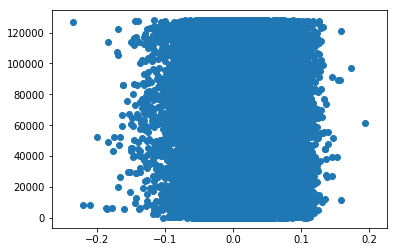

In [12]:
# 绘制权重的散列图
y = range(0,128000)
plt.scatter(load_weights, y)
plt.savefig('./conv9_weights.png')

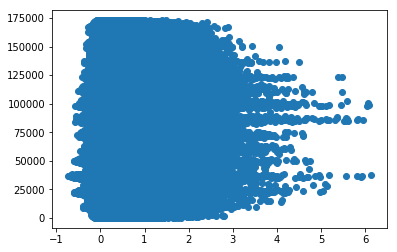

In [13]:
# 绘制特征值的散列图
y = range(0,13*13*1024)
plt.scatter(feature, y)
plt.savefig('./conv9_feature.png')

In [14]:
#最大量化，返回量化后参数和最大值
# max_feature: 找出特征值的最大值
# feature_quant：量化后的特征值 fp32 -> int8
# max_weight：找出权重的最大值
# load_weights_quant：量化后的权重值  fp32 -> int8

#TODO
max_feature = max(abs(feature))
feature_quant = (127*feature/max_feature).astype(np.int8)
max_weight = max(abs(load_weights))
load_weights_quant = (127*load_weights/max_weight).astype(np.int8)

In [15]:
# reshape 量化后的第八层卷积层特征值，拷贝到第九层全连接层的输入特征值
# feature已经被量化，类型值dtype=np.int8
start = time.clock()
feature = np.reshape(feature_quant,(13,13,1024))
conv9_in = xlnk.cma_array(shape=(13,13,1024),cacheable=0,dtype=np.int8)
np.copyto(conv9_in,feature)

# 为weights、bias和cov9_output分配连续的物理地址空间
# weights已经被量化，类型值dtype=np.int8
# bias不做量化，类型值dtype=np.float32
# conv9 output 输出特征值要去量化，类型值dtype=np.float32
weights = xlnk.cma_array(shape=(1,1,1024,125),cacheable=0,dtype=np.int8)
bias = xlnk.cma_array(shape=(125),cacheable=0,dtype=np.float32)
output = xlnk.cma_array(shape=(13,13,125),cacheable=0,dtype=np.float32)

# reshape 量化后的权重值，拷贝给第九层全连接层的权重weights
load_weights = np.reshape(load_weights_quant,(1,1,1024,125))
np.copyto(weights,load_weights)

# 导入第九层全连接层的bias
load_bias = np.loadtxt('./bias/b9.txt')
np.copyto(bias,load_bias)

# 将上一个cell求出的max_feature和max_weight导入卷积IP核，去量化
maxw9_w = xlnk.cma_array(shape=(2),cacheable=0,dtype=np.float32)
max_w = [max_feature,max_weight]
np.copyto(maxw9_w,max_w)
end = time.clock()
print(end-start)

0.037338000000033844


In [16]:
# 执行第九层全连接层IP核，conv9 output需要去量化
start = time.clock()
RunConv(conv_ip,1,1,1,1,1,0,conv9_in,weights,bias,output,maxw9_w)
end = time.clock()
print(end-start)

10.062471000000016


In [17]:
import colorsys
import random
from math import exp

#sigmoid函数，用于神经网络激活函数，将变量映射到0,1之间
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

#softmax逻辑回归，在yolo中用于将20种分类概率转换为一个概率值
def softmax(x):
    e_x = np.exp(x - np.max(x))
    out = e_x / e_x.sum()
    return out

#YOLO最后输出特征为13*13*125，转换为13*13*5*25之后用decode函数把输出特征还原为目标位置和概率
#13*13*5*25表示将图片划分为13*13个网格，每个网格输出5个表示目标位置的边界框，每个框对应25个参数
def decode(feature):
    #anchors表示5个边界框的初始尺寸
    anchors = [1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52]
    #每个框的25个参数中前4个表示框的位置
    x_offset = sigmoid(feature[:,:,:,0])
    y_offset = sigmoid(feature[:,:,:,1])
    w_offset = feature[:,:,:,2]
    h_offset = feature[:,:,:,3]
    class_probs = np.zeros((13,13,5,20),dtype=np.float32)
    obj_probs = np.zeros((13,13,5),dtype=np.float32)
    for i in range(0,13):
        for j in range(0,13):
            for k in range(0,5):
                w_offset[i][j][k] = exp(w_offset[i][j][k])
                h_offset[i][j][k] = exp(h_offset[i][j][k])
                #第5个参数表示框内有目标的概率，后20个表示框内图像对应20中类别的概率
                class_probs[i][j][k] = softmax(feature[i,j,k,5:])
                obj_probs[i][j][k] = sigmoid(feature[i][j][k][4])
                
    x_cell = np.zeros((13,13),dtype=np.float32)
    y_cell = np.zeros((13,13),dtype=np.float32)
    
    for i in range(0,13):
        for j in range(0,13):
            x_cell[i][j] = j
            y_cell[i][j] = i
    x_cell = np.reshape(x_cell,(13,13,1))
    y_cell = np.reshape(y_cell,(13,13,1))
    bbox_x = np.zeros((13,13,5),dtype=np.float32)
    bbox_y = np.zeros((13,13,5),dtype=np.float32)
    bbox_w = np.zeros((13,13,5),dtype=np.float32)
    bbox_h = np.zeros((13,13,5),dtype=np.float32)
    #将框的位置参数还原为框在图片上的坐标
    for i in range(0,13):
        for j in range(0,13):
            for k in range(0,5):
                bbox_x[i][j][k] = (x_cell[i][j][0] + x_offset[i][j][k]) / 13
                bbox_y[i][j][k] = (y_cell[i][j][0] + y_offset[i][j][k]) / 13
    for i in range(0,13):
        for j in range(0,13):
            for k in range(0,5):
                bbox_w[i][j][k] = (anchors[2*k] * w_offset[i][j][k]) / 13
                bbox_h[i][j][k] = (anchors[2*k+1] * h_offset[i][j][k]) / 13
    bboxes = np.stack([bbox_x-bbox_w/2, bbox_y-bbox_h/2,bbox_x+bbox_w/2, bbox_y+bbox_h/2],axis=3)
    return bboxes, class_probs, obj_probs

#bboxes_cut函数用于将超出图片范围的框截断
def bboxes_cut(bbox_min_max,bboxes):
	bboxes = np.copy(bboxes)
	bboxes = np.transpose(bboxes)
	bbox_min_max = np.transpose(bbox_min_max)
	bboxes[0] = np.maximum(bboxes[0],bbox_min_max[0])
	bboxes[1] = np.maximum(bboxes[1],bbox_min_max[1])
	bboxes[2] = np.minimum(bboxes[2],bbox_min_max[2])
	bboxes[3] = np.minimum(bboxes[3],bbox_min_max[3])
	bboxes = np.transpose(bboxes)
	return bboxes

#把框按评分排序，去掉评分低的框，只留下20个
def bboxes_sort(classes,scores,bboxes,top_k=20):
	index = np.argsort(-scores)
	classes = classes[index][:top_k]
	scores = scores[index][:top_k]
	bboxes = bboxes[index][:top_k]
	return classes,scores,bboxes

#计算两个框的IOU值，表示它们之间的重合度
def bboxes_iou(bboxes1,bboxes2):
	bboxes1 = np.transpose(bboxes1)
	bboxes2 = np.transpose(bboxes2)

	int_ymin = np.maximum(bboxes1[0], bboxes2[0])
	int_xmin = np.maximum(bboxes1[1], bboxes2[1])
	int_ymax = np.minimum(bboxes1[2], bboxes2[2])
	int_xmax = np.minimum(bboxes1[3], bboxes2[3])

	int_h = np.maximum(int_ymax-int_ymin,0.)
	int_w = np.maximum(int_xmax-int_xmin,0.)

	int_vol = int_h * int_w
	vol1 = (bboxes1[2] - bboxes1[0]) * (bboxes1[3] - bboxes1[1])
	vol2 = (bboxes2[2] - bboxes2[0]) * (bboxes2[3] - bboxes2[1])
	IOU = int_vol / (vol1 + vol2 - int_vol)
	return IOU

#非极大值抑制，将重合度高的几个框中评分低的消去，只留下评分高的
def bboxes_nms(classes, scores, bboxes, nms_threshold=0.3):
	keep_bboxes = np.ones(scores.shape, dtype=np.bool)
	for i in range(scores.size-1):
		if keep_bboxes[i]:
			overlap = bboxes_iou(bboxes[i], bboxes[(i+1):])
			keep_overlap = np.logical_or(overlap < nms_threshold, classes[(i+1):] != classes[i])
			keep_bboxes[(i+1):] = np.logical_and(keep_bboxes[(i+1):], keep_overlap)

	idxes = np.where(keep_bboxes)
	return classes[idxes], scores[idxes], bboxes[idxes]

#后处理程序
def postprocess(bboxes,obj_probs,class_probs,image_shape=(416,416),threshold=0.3):
	bboxes = np.reshape(bboxes,[-1,4])
	bboxes[:,0:1] *= float(image_shape[1])
	bboxes[:,1:2] *= float(image_shape[0])
	bboxes[:,2:3] *= float(image_shape[1])
	bboxes[:,3:4] *= float(image_shape[0])
	bboxes = bboxes.astype(np.int32)
    #切割超出边界的框
	bbox_min_max = [0,0,image_shape[1]-1,image_shape[0]-1]
	bboxes = bboxes_cut(bbox_min_max,bboxes)

	obj_probs = np.reshape(obj_probs,[-1])
	class_probs = np.reshape(class_probs,[len(obj_probs),-1])
	class_max_index = np.argmax(class_probs,axis=1)
	class_probs = class_probs[np.arange(len(obj_probs)),class_max_index]
    #用有目标的置信度和分类置信度之积作为每一个框的最终评分
	scores = obj_probs * class_probs
    #去掉评分小于threshold的框
	keep_index = scores > threshold
    #分类概率最大的种类即为框中目标的种类
	class_max_index = class_max_index[keep_index]
	scores = scores[keep_index]
	bboxes = bboxes[keep_index]

	class_max_index,scores,bboxes = bboxes_sort(class_max_index,scores,bboxes)
	class_max_index,scores,bboxes = bboxes_nms(class_max_index,scores,bboxes)

	return bboxes,scores,class_max_index
#在原图中画出框，写出分类信息和评分
def draw_detection(im, bboxes, scores, cls_inds, labels, thr=0.3):
    #设置框颜色
	hsv_tuples = [(x/float(len(labels)), 1., 1.)  for x in range(len(labels))]
	colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
	colors = list(
		map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),colors))
	random.seed(10101)
	random.shuffle(colors)
	random.seed(None) 
	# draw image
	imgcv = np.copy(im)
	h, w, _ = imgcv.shape
	for i, box in enumerate(bboxes):
		if scores[i] < thr:
			continue
		cls_indx = cls_inds[i]

		thick = int((h + w) / 300)
        #画框
		cv2.rectangle(imgcv,(box[0], box[1]), (box[2], box[3]),colors[cls_indx], thick)
		mess = '%s: %.3f' % (labels[cls_indx], scores[i])
		if box[1] < 20:
			text_loc = (box[0] + 2, box[1] + 15)
		else:
			text_loc = (box[0], box[1] - 10)
        #写字
		cv2.putText(imgcv, mess, text_loc, cv2.FONT_HERSHEY_SIMPLEX, 1e-3*h, (255,255,255), thick//3)
	return imgcv


In [18]:
#输出特征转换为13,13,5,25尺寸
output = np.reshape(output,(13,13,5,25))
#读取原图并转换为与输出特征匹配的尺寸
image1 = cv2.imread("dog.jpg")
image1 = cv2.resize(image1,(416,416),interpolation=cv2.INTER_CUBIC)
#将输出特征还原为目标位置和评分
bboxes, class_p, obj_p = decode(output)
bboxes, scores, class_max_index = postprocess(bboxes,obj_p,class_p)
#画框，保存
class_names = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
img_detection = draw_detection(image1, bboxes, scores, class_max_index, class_names)
cv2.imwrite('output_quant.jpg',img_detection)

True